<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/10_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Paper Replicating

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version son olarak 1.12+ ve üstü olmalıdır."
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version 0.13+ üstü olmalıdır."
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision verisonlarını güncel hale getirmeliyiz!")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Torchinfo yoksa indirilecek.
try:
    from torchinfo import summary
except:
    print("[INFO] Torchinfo bulanamadı. İndiriliyor.")
    !pip install -q torchinfo
    from torchinfo import summary

# Github'tan dosyalar indirilsin.
try:
    from Module_Files import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Module_Files adlı dosyalar
    print("[INFO] Github dosyaları indiriliyor.")
    !git clone https://github.com/ugursirvermez/PyTorch_Education/
    !mv PyTorch_Education/Module_Files .
    !rm -rf PyTorch_Education
    from Module_Files import data_setup, engine

    # MRDBOURKE'un Helper_Functions'ı
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # Helper_Functions by mrdbourke
    !rm -rf pytorch-deep-learning
    from helper_functions import download_data, set_seeds, plot_loss_curves

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
[INFO] Torchinfo bulanamadı. İndiriliyor.
[INFO] Github dosyaları indiriliyor.
Cloning into 'PyTorch_Education'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 556 (delta 25), reused 3 (delta 3), pack-reused 503 (from 2)
Receiving objects: 100% (556/556), 65.80 MiB | 30.69 MiB/s, done.
Resolving deltas: 100% (118/118), done.
data/pizza_steak_sushi Dosyası olusturuluyor
İndiriliyor...
Sıkıştırılmış dosyada çıkarılıyor...
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##Aşama-2: Veri Alma

[INFO] data/pizza_steak_sushi directory exists, skipping download.
Transforma boyutu 224'ten oluşturuldu: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


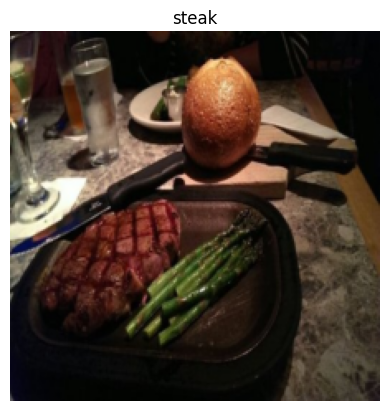

In [3]:
#GitHub MrDbourke içeriğini indiriyoruz.
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
#Train ve Test veri yollarını oluşturuyoruz.
train_dir = image_path / "train"
test_dir = image_path / "test"

#ViT için yükseklik ve genişliği 224x224=4096 haline getirmeliyiz.
IMG_SIZE = 224

# Elle Transform'u oluşturalım.
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Transforma boyutu 224'ten oluşturuldu: {manual_transforms}")

# Batch Miktarı
BATCH_SIZE = 32 #Normalde 4096 olmalı ama yüksek bir sistemimiz yok. Dolayısıyla 32'de kalacağız.

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # Yukarıda oluşturduğumuz transform ile devam edeiyoruz.
    batch_size=BATCH_SIZE
)

# GÖRSELLEŞTİRME YAPALIM
# Resimlerin batch'te olanlarını alalım.
image_batch, label_batch = next(iter(train_dataloader))

# Batch'ten bir resim alalım.
image, label = image_batch[0], label_batch[0]

# Görselleştirelim.
plt.imshow(image.permute(1, 2, 0)) #  [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

##Aşama-3: Verileri Bölme Sınıf, Konum ve Patch Ayarlama

In [4]:
# Örnek bir Veri Oluşturalım.
height = 224 # H
width = 224 # W
color_channels = 3 # C -> Renk kanalları
patch_size = 16 # P

# Patch sayısını oluşturma
number_of_patches = int((height * width) / patch_size**2)
print(f"Patch Sayısı (N) with Resim Yüksekliği (H={height}), Genişliği (W={width}) ve Patch Miktarı (P={patch_size}): {number_of_patches}")

Patch Sayısı (N) with Resim Yüksekliği (H=224), Genişliği (W=224) ve Patch Miktarı (P=16): 196


In [5]:
# Girdi biçimi (Input Shape) -> H, W, C
embedding_layer_input_shape = (height, width, color_channels)

# Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Girdi biçimi (Input Shape) -> H, W, C: {embedding_layer_input_shape}")
print(f"Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C: {embedding_layer_output_shape}")

Girdi biçimi (Input Shape) -> H, W, C: (224, 224, 3)
Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C: (196, 768)


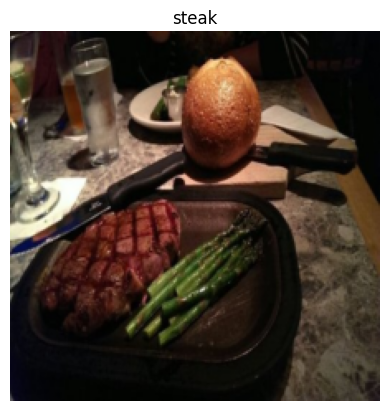

In [6]:
# Resmi Görüntüleme
plt.imshow(image.permute(1, 2, 0)) #Output Shape
plt.title(class_names[label])
plt.axis(False);

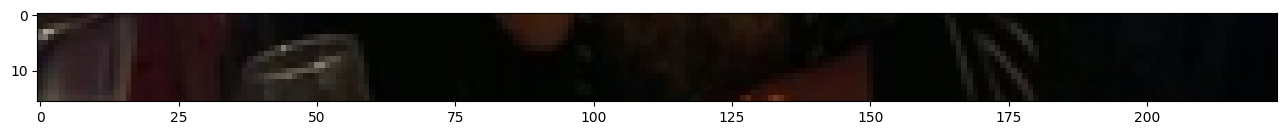

In [7]:
#(color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Patch miktarı belirtelim ve pikselleri görelim.
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Her Satırdaki patch sayısı: 14.0
Patch boyutu: 16 pixel x 16 pixel


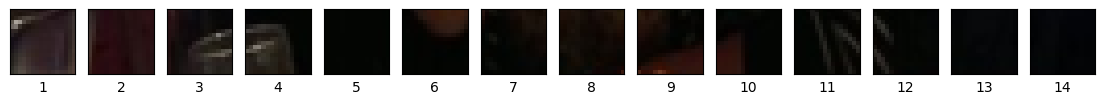

In [8]:
# img_size ve patch_size değerlerini yazıyoruz. Burada bir karşılaştırma yapabiliriz.
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Resim boyutu, patch boyutuna bölümünden kalan sıfır olana kadar"
print(f"Her Satırdaki patch sayısı: {num_patches}\nPatch boyutu: {patch_size} pixel x {patch_size} pixel")

# Patch'leri görüntülemek için bir plot dizisi oluşturalım.
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # bir sütundaki her bir patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Resimleri etiketleri ile yan yana görüntüleyelim.
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # Yükseklik ve genişlik yan yana
    axs[i].set_xlabel(i+1) # Etiket
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Satırdaki Patch Sayısı: 14.0        
Sütundaki Patch Sayısı: 14.0        
Toplam Patch Sayısı: 196.0        
Patch Boyutu: 16 pixel x 16 pixel


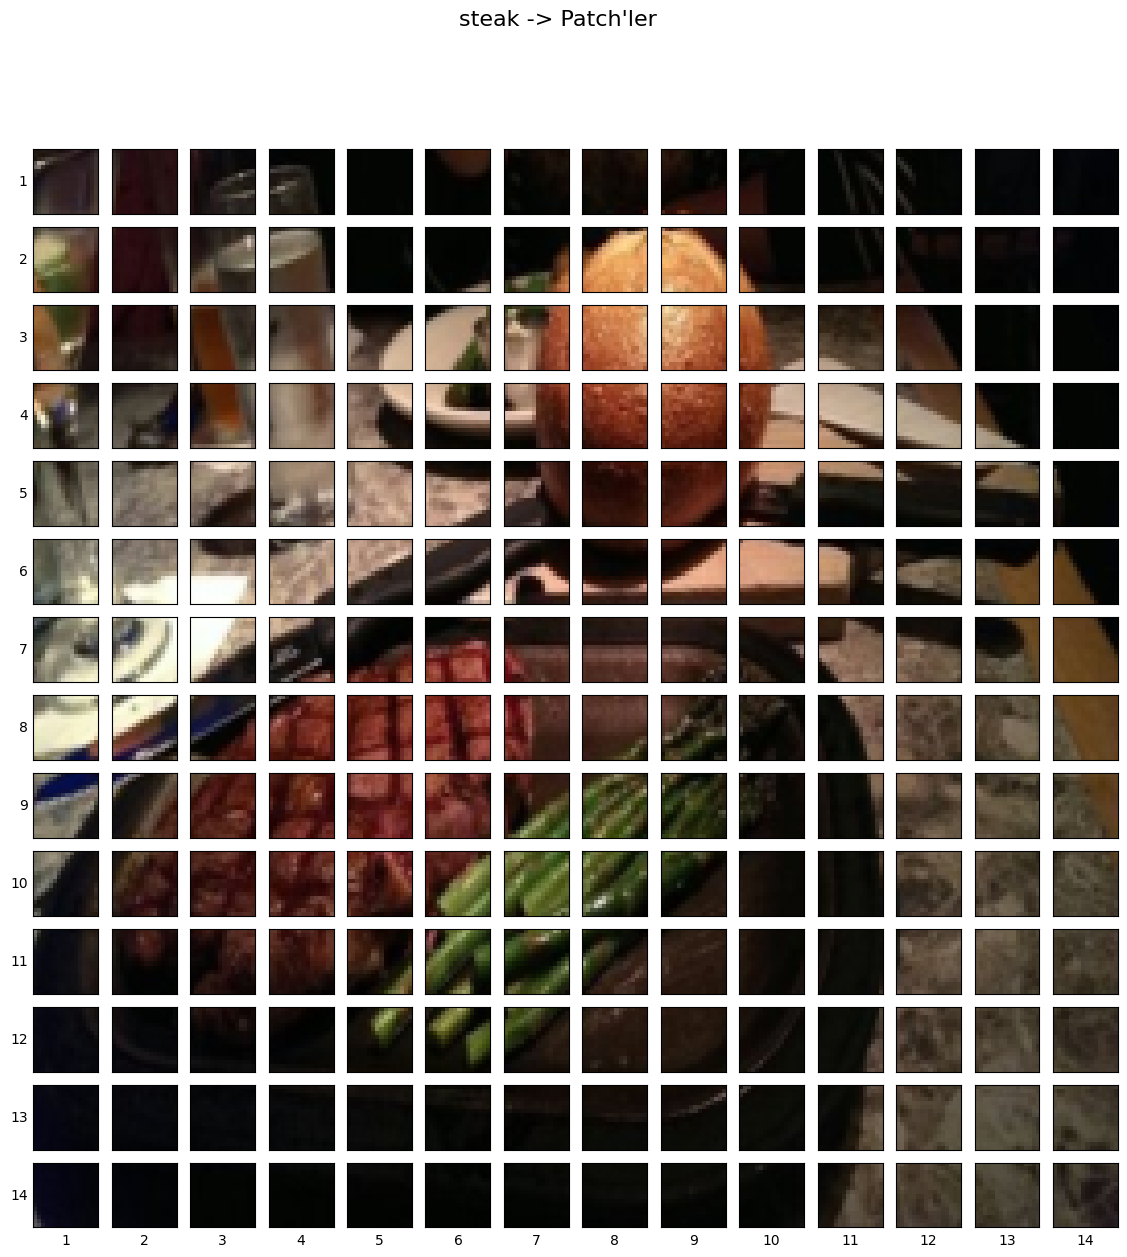

In [9]:
# img_size ve patch_size değerlerini yazıyoruz. Burada bir karşılaştırma yapabiliriz.
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Resim boyutu, patch boyutuna bölümünden kalan sıfır olana kadar"
print(f"Satırdaki Patch Sayısı: {num_patches}\
        \nSütundaki Patch Sayısı: {num_patches}\
        \nToplam Patch Sayısı: {num_patches*num_patches}\
        \nPatch Boyutu: {patch_size} pixel x {patch_size} pixel")

# Patch'leri görüntülemek için bir plot dizisi oluşturalım.
fig, axs = plt.subplots(nrows=img_size // patch_size, # int değerinde olmalı, float olamaz!
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Döngüler halinde her bir patch'i resmin yükseklik ve genişliğine oranla yerleştirelim.
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # image_permuted -> (Height, Width, Color Channels)
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        # Etiketleri yazdırma
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Grafiğe Ana Başlık
fig.suptitle(f"{class_names[label]} -> Patch'ler", fontsize=16)
plt.show()

5 Evrimsel Boyut: [294, 441, 169, 412, 257]


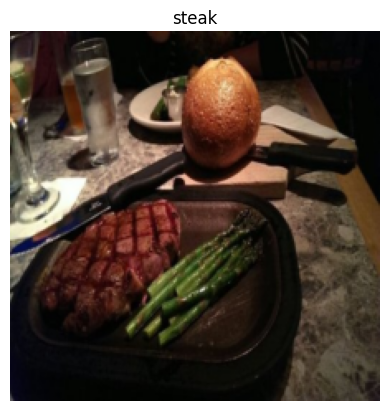

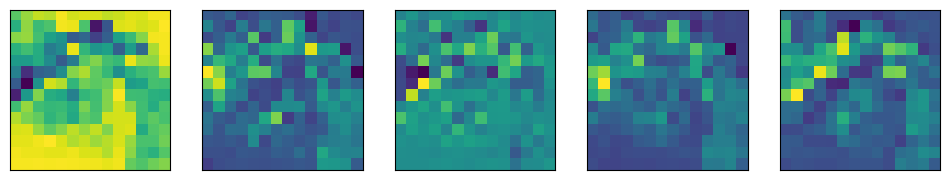

In [10]:
from torch import nn

# Patch Miktarı
patch_size=16

# Conv2d katmanı fakat ViT'nin istediği değerlerde yani channel X Patch x Patch
conv2d = nn.Conv2d(in_channels=3, # renk kanal sayısı
                   out_channels=768, # Embed size
                   kernel_size=patch_size, # patch_size, patch_size
                   stride=patch_size,
                   padding=0)

# Resmi görelim
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

# convolutional layer'da boyut ekleyelim.
image_out_of_conv = conv2d(image.unsqueeze(0)) #(height, width, color_channels) -> (batch, height, width, color_channels)
# Rasgele 5 Evrimsel Boyut Ekleyelim.
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"5 Evrimsel Boyut: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
# Görselleştirelim.
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [11]:
# Tek bir öğrenme verisinin değerlerine bakalım.
single_feature_map = image_out_of_conv[:, 0, :, :]
print(single_feature_map, single_feature_map.requires_grad)

tensor([[[-0.1586, -0.0802, -0.0292, -0.0502, -0.0345, -0.0898, -0.0638,
          -0.0674, -0.0760, -0.0390, -0.0395, -0.0359, -0.0417, -0.0439],
         [-0.2739, -0.0670, -0.0955, -0.2262, -0.0348, -0.1216, -0.1119,
          -0.2010, -0.2178, -0.0463, -0.0526, -0.0687, -0.0583, -0.0429],
         [-0.1358, -0.0972, -0.1420, -0.1756,  0.0546, -0.1750, -0.2376,
          -0.3523, -0.4650, -0.2386, -0.1102, -0.1067, -0.0349, -0.0349],
         [-0.2387, -0.1085, -0.1669, -0.3048, -0.4766, -0.1495, -0.2527,
          -0.2559, -0.2684, -0.2357, -0.2114, -0.1355, -0.1010, -0.0333],
         [-0.1579, -0.2550, -0.3502, -0.3069, -0.3321,  0.0118, -0.0556,
          -0.1147, -0.1157, -0.2771, -0.2793, -0.1444, -0.2482, -0.0316],
         [-0.2274, -0.3158, -0.1106, -0.1757, -0.4083, -0.1736,  0.0829,
          -0.0023,  0.1102, -0.2842, -0.1307,  0.0870, -0.0304, -0.0832],
         [-0.2215, -0.3511, -0.5600, -0.3686, -0.1425, -0.0383, -0.0503,
          -0.0352, -0.0319, -0.1284, -0.1436,

In [12]:
# Tensörümüzün Şekli
print(f"Mevcut Tensör Şeklimiz: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Mevcut Tensör Şeklimiz: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [13]:
#Flatten Katman Oluşturma
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (boyut 2)
                     end_dim=3) # flatten feature_map_width (boyut 3)

Resmin İlk Şekli: torch.Size([3, 224, 224])
Resmin Özellik Şekli: torch.Size([1, 768, 14, 14])
Flatten Edilmiş Görselin Şekli: torch.Size([1, 768, 196])


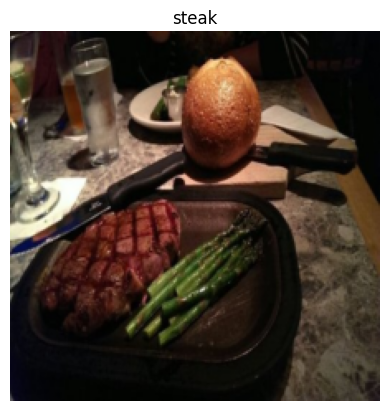

In [14]:
# 1. Single Resimi Alalım
plt.imshow(image.permute(1, 2, 0)) # matplotlib'te görünecek hale getirelim.
plt.title(class_names[label]) #Etiketleri yazdır.
plt.axis(False);
print(f"Resmin İlk Şekli: {image.shape}")

# 2. Özellikleri Haritalaştıralım
image_out_of_conv = conv2d(image.unsqueeze(0)) #batch'e bir boyut ekleyip şekil hatalarından kaçınalım.
print(f"Resmin Özellik Şekli: {image_out_of_conv.shape}")

# 3. Flatten Edilmiş Görselin Şekli
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flatten Edilmiş Görselin Şekli: {image_out_of_conv_flattened.shape}")

In [15]:
 #196, 768 değerlerinin yerini değiştireceğiz.
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Sekans boyutunun Değişimi: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Sekans boyutunun Değişimi: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


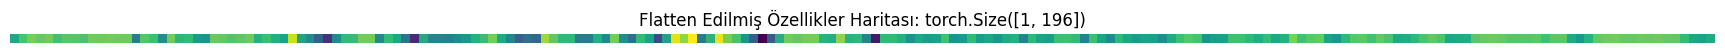

In [16]:
# flatten edilmiş özellikler haritası (Tek satır)
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Yukarıdaki değişkeni görselleştirelim
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flatten Edilmiş Özellikler Haritası: {single_flattened_feature_map.shape}")
plt.axis(False);

In [17]:
# 1.Adım: nn.Module'den bir Patch için çalışacak sınıf oluşturalım.
class PatchEmbedding(nn.Module):
    """2D bir resmi tek boyutlu bir metin vektörüne çevireceğiz.

    Args:
        in_channels (int): Renk kanallarıdır. Minimum, başlangıç değerini 3 alacağız.
        patch_size (int): Patch miktarını input'a çevirecek. başlangıç değerini 16 alacağız.
        embedding_dim (int): Embed edilecek boyutlar. başlangıç değerini 768 alacağız.
    """
    # 2.Adım: Modülde çalışacak değişkenlerimizi tanımlayalım.
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3.Adım: conv2d ile resmi patch'lere bölelim.
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4.Adım: Flatten ederek resmi tek bir boyuta düzleştirmek için bir katman oluşturalım.
        self.flatten = nn.Flatten(start_dim=2, # Tek bir vektöre dönüşecek.
                                  end_dim=3)

    # 5.Adım: Forward metodu, klasik.
    def forward(self, x):
        # Resim kalitesinden ödün vermemek için şekli düzenleyelim.
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Resim patch miktarına bölünecek. Resmin Şekli: {image_resolution}, Patch Miktarı: {patch_size}"

        # Forward Edelim.
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6.Adım: Resmin çıktı şeklini kontrol edelim.
        return x_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

#ÇALIŞTIRALIM...
# Patch embed katmanlı değişken tasarlayalım.
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Bir resmi çalıştıralım.
print(f"Input Shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # Hata çıkmaması için katman ekledik.
print(f"Output patch embed shape: {patch_embedded_image.shape}")

Input Shape: torch.Size([1, 3, 224, 224])
Output patch embed shape: torch.Size([1, 196, 768])


In [18]:
# Rastgele girdi veri oluşturalım.
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

# Summary ile, Patch Embedding'in katmanlarına bakalım.
summary(PatchEmbedding(),
         input_size=random_input_image,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [19]:
# Batch miktarı ve embedding boyutunu alalım
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Embedding'ler için her bir boyuta bir token oluşturalım.
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # embed edileni öğretilebilir hale getiriyoruz.

# class_token değişkeninin ilk 10 birimini yazdıraım.
print(class_token[:, :, :10])
print(f"class_token Biçimi: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class_token Biçimi: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [20]:
# Sınıfı belirleyen class_token'i patch'in önüne alacağız.
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # dim =1

# Yazdıralım.
print(patch_embedded_image_with_class_embedding)
print(f"Patch sekansında sınıf belirteci önde: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.2560, -0.1527,  0.0333,  ...,  0.0586,  0.0148, -0.1386],
         [ 0.1370, -0.1522, -0.0015,  ...,  0.0012, -0.0436, -0.0406],
         ...,
         [ 0.2713, -0.2308,  0.0932,  ...,  0.0561, -0.0446, -0.0905],
         [ 0.2592, -0.2127,  0.1319,  ...,  0.0531, -0.0142, -0.0966],
         [ 0.2089, -0.1677,  0.0905,  ...,  0.0189, -0.0885, -0.1198]]],
       grad_fn=<CatBackward0>)
Patch sekansında sınıf belirteci önde: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [21]:
# N Hesaplama (patch miktarı sayısı)
number_of_patches = int((height * width) / patch_size**2)

# embedding boyutu ekleme
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Öğrenilebilir 1D embedding pozisyonu oluşturma
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # grad öğrenilebilir olduğunu bize söylüyor.

# İlk 10 verinin 1D pozisyonuna bakalım
print(position_embedding[:, :10, :10])
print(f"Position embedding Şekli: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

# Position Enbedding'i patch'e class_token ile birlikte ekleme
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embedding'ler, class token + positional embeddings: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding Şekli: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]
tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.2560, 0.8473, 1.0333,  ..., 1.0586, 1.0148, 0.8614],
         [1.1370, 0.8478, 0.9985,  ..., 1.0012, 0.9564, 0.9594],
         ...,
         [1.2713, 0.7692, 1.0932,  ..., 1.0561, 0.9554, 0.9095],
         [1.2592, 0.7873, 1.1319,  ..., 1.0531, 0.9858, 0.9034],
         [1.208

In [22]:
set_seeds()

# 1. Patch Miktarını Ayarla
patch_size = 16

# 2. Orjinal resmin tensör boyutunu yazdıralım
print(f"Resim tensör Shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. resim tensöre ekstra bir batch boyutu ekle
x = image.unsqueeze(0)
print(f"Ekstra batch boyutu eklenmiş, Resim Tensörü: {x.shape}")

# 4. Patch Embedding Katmanı Ekleme
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Resmi Embedding Katmanından Geçirme
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Class Token'i Embedding'e Ekleme
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # Öğrenilebilir yaptık.
print(f"Class Token Embedding Shape: {class_token.shape}")

# 7. Patch'i ClassToken'li hale getirdik.
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch Embedding + Class Token Shape: {patch_embedding_class_token.shape}")

# 8. Position Embedding'le bir araya getirdik.
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # Öğrenilebilir yaptık.

# 9. Position Embedding + Class Token + Patch Embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding

Resim tensör Shape: torch.Size([3, 224, 224])
Ekstra batch boyutu eklenmiş, Resim Tensörü: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class Token Embedding Shape: torch.Size([1, 1, 768])
Patch Embedding + Class Token Shape: torch.Size([1, 197, 768])


##MSA -> Multi-Head Attention

In [23]:
# 1. nn.Module ile MSA
class MultiheadSelfAttentionBlock(nn.Module):

    # 2. Başlatılırken lazım olacak alt parametreleri tanıtalım.
    def __init__(self,
                 embedding_dim:int=768, # Gizli katman
                 num_heads:int=12, # Başlık sayısı
                 attn_dropout:float=0): # Düşecek nesnes sayısı
        super().__init__()

        # 3. LN Tasarlama
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. MSA Katmanı Oluşturma
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) #batch boyutu ilk gelsin

    # 5. forward() ederek devam etma
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query
                                             key=x, # key
                                             value=x, # value
                                             need_weights=False) #weight çıktı da olmalı mı?
        return attn_output

In [24]:
# MSABlock Oluşturma
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

# MSA'yı Yazdırma
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"MSA block Girdi Şekli: {patch_and_position_embedding.shape}")
print(f"MSA block Çıktı Şekli: {patched_image_through_msa_block.shape}")

MSA block Girdi Şekli: torch.Size([1, 197, 768])
MSA block Çıktı Şekli: torch.Size([1, 197, 768])


## MLP -> Multilayer Perceptron

In [25]:
# 1. nn.Module ile MLPBlock
class MLPBlock(nn.Module):

    # 2. Girilecek parametreleri oluştur.
    def __init__(self,
                 embedding_dim:int=768, # Gizli Katman
                 mlp_size:int=3072, # MLP miktarı
                 dropout:float=0.1): # Dropout miktarı
        super().__init__()

        # 3. LN KAtmanı Oluşturma
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. MLP Katmanları Oluşturma
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # non-linear katman
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout) #Dropout ayarlama
        )

    # 5. forward()
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [26]:
# MLPBlock Nesnesi
mlp_block = MLPBlock(embedding_dim=768,mlp_size=3072, dropout=0.1)

# Yazdıralım.
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"MLP Girdi Şekli: {patched_image_through_msa_block.shape}")
print(f"MLP Çıktı Şekli: {patched_image_through_mlp_block.shape}")

MLP Girdi Şekli: torch.Size([1, 197, 768])
MLP Çıktı Şekli: torch.Size([1, 197, 768])


##Transform Encoder

In [27]:
# 1. nn.Module ile TransformerEncoder oluşturalım.
class TransformerEncoderBlock(nn.Module):

    # 2. Parametreleri ayarlıyoruz.
    def __init__(self,
                 embedding_dim:int=768, # Gizli katmanlar
                 num_heads:int=12, # Başlık sayısı
                 mlp_size:int=3072, # MLP miktarı
                 mlp_dropout:float=0.1, # dropout miktarı
                 attn_dropout:float=0): # dropout katman sayısı
        super().__init__()

        # 3. MSA bloğu
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. MLP bloğu
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. forward() metodu
    def forward(self, x):

        # 6. residual connection MSA bloğu için -> output'a input ekledik.
        x =  self.msa_block(x) + x

        # 7. residual connection MLP bloğu için -> output'a input ekledik.
        x = self.mlp_block(x) + x

        return x

In [28]:
# Nesne oluşturalım (Sınıftan türetme)
transformer_encoder_block = TransformerEncoderBlock()

# Summary ile özetleyelim.
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

##ViT Mimarisini Oluşturma

In [29]:
# 1. nn.Module'den bir ViT modülü oluşturalım.
class ViT(nn.Module):

    # 2. Parametrelerimizi oluşturalım.
    def __init__(self,
                 img_size:int=224, # Eğitim Çözünürlüğü
                 in_channels:int=3, # Girdi resimler kaç renk kanallı?
                 patch_size:int=16, # Patch Miktarı
                 num_transformer_layers:int=12, # Katman Sayısı
                 embedding_dim:int=768, # Gizli Katman Boyutu
                 mlp_size:int=3072, # MLP Miktarı
                 num_heads:int=12, # ViT-Temelli Başlıklar
                 attn_dropout:float=0, # Dropout attention
                 mlp_dropout:float=0.1, # Dropout için MLP Katmanları
                 embedding_dropout:float=0.1, # patch and position embeddings için dropout
                 num_classes:int=1000): # ImageNet'e ayarlı.
        super().__init__()

        # 3. Patch miktarına resmin bölünebilir olduğunu kontrol eetmek gerekiyor.
        assert img_size % patch_size == 0, f"Resim patch miktarına bölünebilir olmalıdır: {img_size}, patch miktarı: {patch_size}."

        # 4. Patch'i Hesaplama (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Öğrenilebilir sınıf embedding'leri oluşturma (patch embedding sekansının önüne eklenirdi)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Öğrenilebilir Pozisyon Embedding'leri ekleme
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Dropout Değeri oluşturma
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Patch Embedding Katmanı Oluşturma
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Transformer Encoder bloğu ekleme (nn.Sequential() ile birlikte)
        # Yıldız işareti hepsini al demek
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Sınıf başlığı oluşturma
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Forward() Metodu
    def forward(self, x):

        # 12. Batch Miktarı al.
        batch_size = x.shape[0]

        # 13. Class token ekle ve batch miktarını bunun için bir büyüt.
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Patch Embedding yap.
        x = self.patch_embedding(x)

        # 15. Cat ile patch embedding ve class_token'i birleştir.
        x = torch.cat((class_token, x), dim=1)

        # 16. position embedding'i patch embedding'e ekle.
        x = self.position_embedding + x

        # 17. embedding dropout çalıştır.
        x = self.embedding_dropout(x)

        # 18. patch, position ve class embedding'i transformer encoder katmanlarına geçir.
        x = self.transformer_encoder(x)

        # 19. Bir sıfır indeksi ekleyerek sınıflandırmaları genişlet (Bu dizi boyutunu arttırır.)
        x = self.classifier(x[:, 0])

        # 20. İşlem bu kadar!
        return x

In [30]:
#Batch + class_token oluşturma
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

# Yazdır
print(f"class token embedding tekli: {class_token_embedding_single.shape}")
print(f"class token embedding genişletilmiş: {class_token_embedding_expanded.shape}")

class token embedding tekli: torch.Size([1, 1, 768])
class token embedding genişletilmiş: torch.Size([32, 1, 768])


In [31]:
#Seed atalım.
set_seeds()

# Rastgele Tensör oluşturalım.
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# ViT'ye uygun biftek, pizza ve suşi sınıf numarasını verelim.
vit = ViT(num_classes=len(class_names))

# ViT'den tensörü geçirelim.
print(vit(random_image_tensor))

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)


In [32]:
from torchinfo import summary

# ViT Modelini inceleyelim.
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"],
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape
ViT (ViT)                                                    [32, 3, 224, 224]
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]
│    └─Flatten (flatten)                                     [32, 768, 14, 14]
├─Dropout (embedding_dropout)                                [32, 197, 768]
├─Sequential (transformer_encoder)                           [32, 197, 768]
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]
│    │    └─MLPBlock (mlp_block)                             [32, 197, 768]
│    └─TransformerEncoderBlock (1)                           [32, 197, 768]
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]
│    │    └─MLPBlock (mlp_block)                             [32, 197, 768]
│  

##ViT Modeline Uygun Eğitilebilir Veri Hazırlama

In [33]:
from Module_Files import engine

# Optimizer'ı ViT Modeline göre Adam fonksiyonu ile oluşturuyorux.
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, #ImageNet-1k'nın base değeridir.
                             betas=(0.9, 0.999), # eğitim için ViT makalesinde bahsedilen değer budur.
                             weight_decay=0.3) # weight değeri yine makaleden alıntıdır.

# loss fonksiyonunu multi-class sınıflandırma için CrossEntropyLoss yapıyoruz.
loss_fn = torch.nn.CrossEntropyLoss()

# seed atıyoruz.
set_seeds()

# Modeli eğittik ve yazdırıyoruz.
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


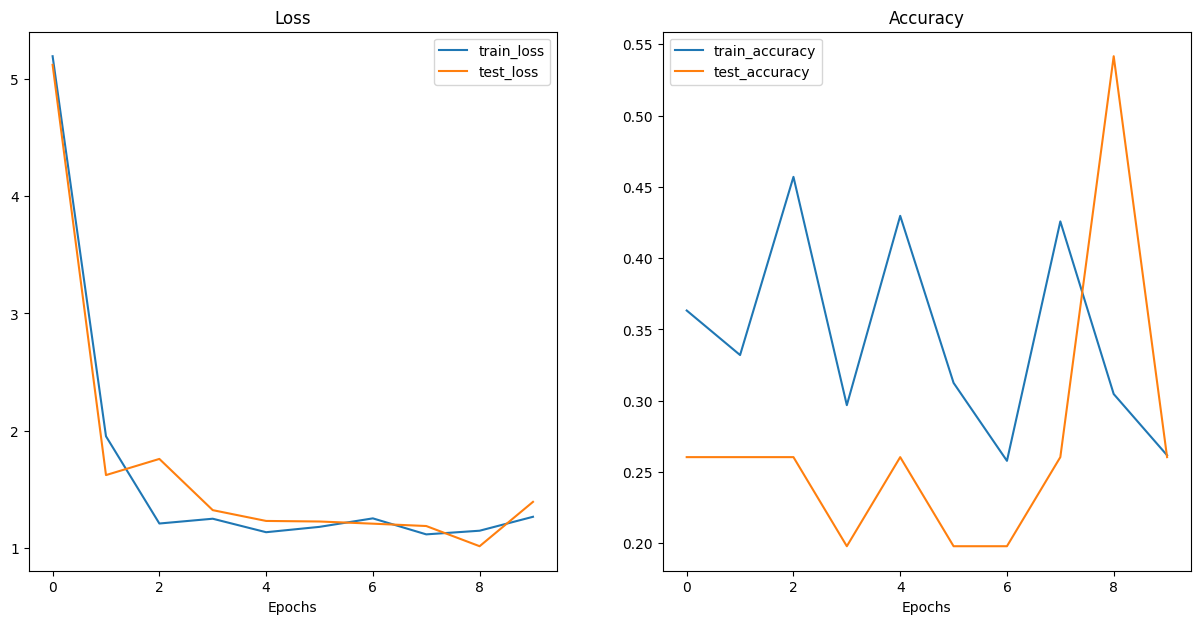

In [34]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

##Önceden Eğitilmiş Model ve Veriyle Çalışmak

In [35]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. ViT Temelli önceden eğitilmiş weight alıyoruz.
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # torchvision >= 0.13 üstünde çalışıyor

# 2.ViT modeli önceden eğitilmiş veri ile dolduralım.
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Temel parametreleri donduralım.
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Sınıflandırıcı başlıklarını değiştiriyoruz. Kendi 3 başlıklı class_name ekliyoruz.
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

#Summary ile modele bakalım.
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], #Küçük veri de bu kullanılmaz
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 53.8MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [36]:
from helper_functions import download_data
from Module_Files import engine

# pizza, steak, sushi resimleri by mrdbourke
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

# train ve test yolları
train_dir = image_path / "train"
test_dir = image_path / "test"

# önceden eğitilmiş ViT weights otomatik transformlarda
pretrained_vit_transforms = pretrained_vit_weights.transforms()

#Dataloaders ayarlayalım.
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # https://arxiv.org/abs/2205.01580 daha fazla batch yapılabilir.

# Optimizer ve Loss
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
#Loss
loss_fn = torch.nn.CrossEntropyLoss()

# Başlıklar vs ile çalıştıralım.
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)



[INFO] data/pizza_steak_sushi directory exists, skipping download.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


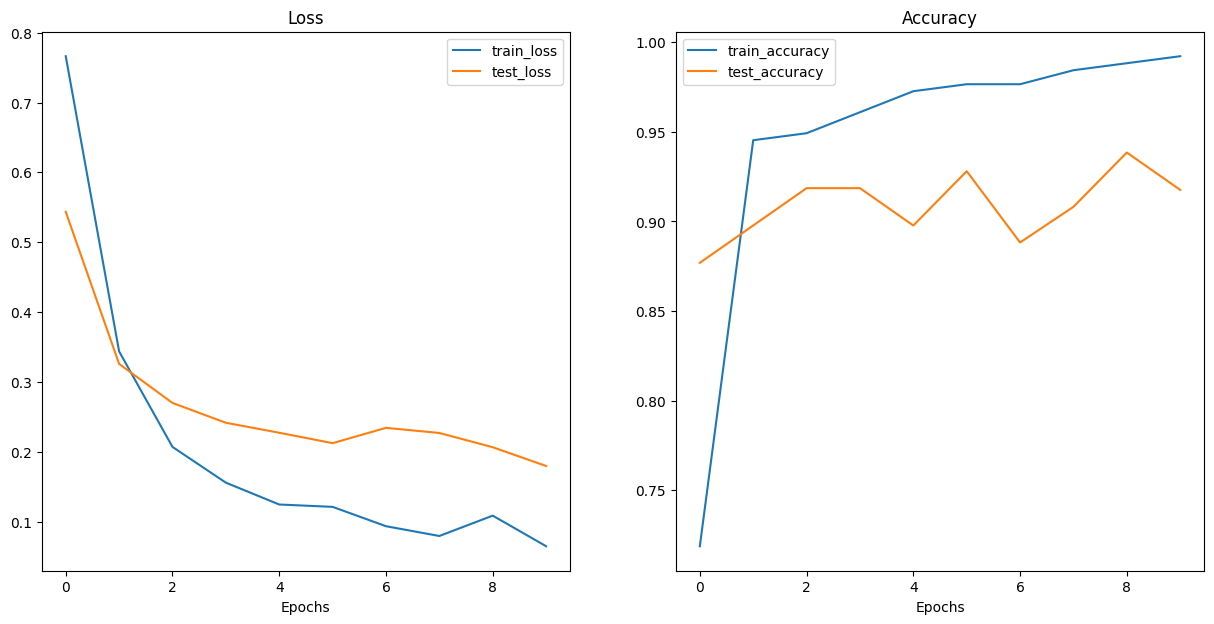

In [37]:
plot_loss_curves(pretrained_vit_results)

In [39]:
# Modeli Kaydedelim.
from Module_Files import utils
from pathlib import Path

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_FoodVisionMini.pth")

# Model boyutunu yazdıralım.
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_FoodVisionMini.pth").stat().st_size // (1024*1024) # byte -> megabyte
print(f"Pretrained ViT feature extractor model Boyutu: {pretrained_vit_model_size} MB")

[INFO] Modelin Kaydedildiği Yer: models/08_pretrained_vit_feature_FoodVisionMini.pth
Pretrained ViT feature extractor model Boyutu: 327 MB
